# Import Dataset

In [1]:
import pandas as pd
labels_file = "/teamspace/studios/flexible-rose-w24m/folds.csv"

df = pd.read_csv(labels_file)

df["label"].value_counts()


label
1    35884
0     2650
Name: count, dtype: int64

In [2]:
import os
import cv2
import pandas as pd
import torch
from concurrent.futures import ThreadPoolExecutor
from torchvision import transforms
from itertools import islice

crops_dir = "/teamspace/studios/flexible-rose-w24m/sample_dataset/crops"
labels_file = "/teamspace/studios/flexible-rose-w24m/folds.csv"

# Read labels CSV
labels_df = pd.read_csv(labels_file)

# Define transform
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def process_image(row):
    """Load, resize, and transform an image."""
    video_name, file_name, label = row['video'], row['file'], row['label']
    img_path = os.path.join(crops_dir, video_name, file_name)
    if not os.path.exists(img_path):
        return None 

    img = cv2.imread(img_path)
    if img is None:
        return None 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_img = data_transform(img)
    return transformed_img, label

def chunks(iterable, size):
    """Yield successive n-sized chunks from an iterable."""
    iterator = iter(iterable)
    for first in iterator:
        yield [first, *islice(iterator, size - 1)]

# Process data in batches
batch_size = 1000  
images = []
labels = []

for batch in chunks(labels_df.to_dict('records'), batch_size):
    with ThreadPoolExecutor(max_workers=32) as executor:
        results = list(executor.map(process_image, batch))
        # Collect successful results
        for res in results:
            if res is not None:
                images.append(res[0])
                labels.append(res[1])

# # Convert to tensors
# images = torch.stack(images)
# labels = torch.tensor(labels, dtype=torch.long)

# # Split dataset
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# print(f"Processed {len(images)} images")
# print(f"Split into {len(X_train)} training and {len(X_test)} testing samples")


In [3]:
len(images)

38534

In [8]:
labels[0]

1

In [10]:
images = torch.stack(images)
labels = torch.tensor(labels, dtype=torch.long)

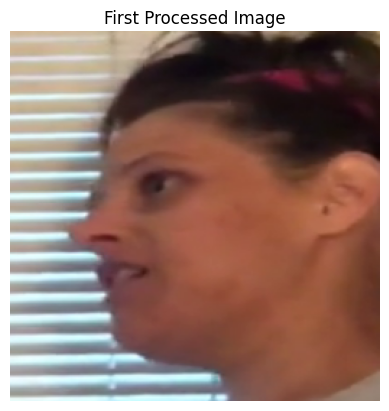

In [11]:
import matplotlib.pyplot as plt

# Convert the first image tensor to a NumPy array
first_image = images[0].permute(1, 2, 0).numpy()  # Rearrange dimensions (C, H, W) -> (H, W, C)

# Plot the image
plt.imshow(first_image)
plt.axis('off')  # Hide axes for better visualization
plt.title("First Processed Image")
plt.show()


In [12]:
# File paths to save tensors
images_path = "sd_images.pt"
labels_path = "sd_labels.pt"

# Save tensors
torch.save(images, images_path)
torch.save(labels, labels_path)

print(f"Images saved to {images_path}")
print(f"Labels saved to {labels_path}")

Images saved to sd_images.pt
Labels saved to sd_labels.pt


# Train-Validation Split

In [1]:
import os
import cv2
import pandas as pd
import torch
from concurrent.futures import ThreadPoolExecutor
from torchvision import transforms
from itertools import islice
# Load tensors
images = torch.load("sd_images.pt")
labels = torch.load("sd_labels.pt")

print(f"Loaded images shape: {images.shape}")
print(f"Loaded labels shape: {labels.shape}")

Loaded images shape: torch.Size([38534, 3, 256, 256])
Loaded labels shape: torch.Size([38534])


In [3]:
# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [4]:
X_train.shape

torch.Size([30827, 3, 256, 256])

In [5]:
# Get unique labels and their counts
unique_labels, label_counts = torch.unique(y_train, return_counts=True)

# Display label counts
for label, count in zip(unique_labels, label_counts):
    print(f"Label: {label.item()}, Count: {count.item()}")

Label: 0, Count: 2143
Label: 1, Count: 28684


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, TensorDataset
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

images = torch.load("/teamspace/studios/written-violet-bdv7/train_images.pt")
print("3")
labels = torch.load("/teamspace/studios/written-violet-bdv7/train_labels.pt")
print("4")


X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

3
4


## Base models

- Resnet18
- Effcientnet
- Nasnet-Large


In [2]:
def get_nasnetlarge_base_model(num_classes=2):
    model = timm.create_model('nasnetalarge', pretrained=False)
    model.last_linear = nn.Linear(model.num_features, num_classes)
    return model.to(device)

def get_efficientnetb0_base_model(num_classes=2):
    model = timm.create_model('efficientnet_b0', pretrained=False)
    model.classifier = nn.Linear(model.num_features, num_classes)
    return model.to(device)

def get_resnet18_base_model(num_classes=2):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

In [9]:
# model = get_nasnetlarge_base_model()
# model = get_efficientnetb0_base_model()
model = get_resnet18_base_model() 


scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.7, 1.3]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
best_val_loss = float("inf")
best_model_path = "base_resnet.pt"

epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)

        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()
        torch.cuda.empty_cache()

    # Step the learning rate
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = [] 

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            with torch.cuda.amp.autocast():
                val_outputs = model(X_val)
                val_loss += loss_fn(val_outputs, y_val).item()
                _, preds = torch.max(val_outputs, 1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

                probabilities = torch.softmax(val_outputs, dim=1)[:, 1]
                all_probs.extend(probabilities.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

            torch.cuda.empty_cache()

    val_loss /= len(test_loader)
    accuracy = correct / total

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model.")

    # Calculate AUC
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = None  

    all_preds_binary = [1 if pred >= 0.5 else 0 for pred in all_probs]
    weighted_precision = precision_score(all_labels, all_preds_binary, average='weighted')
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy * 100:.2f}%, AUC: {auc if auc is not None else 'Undefined'}, Weighted Precision: {weighted_precision:.4f}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50]: Validation loss improved to 0.5830. Saving model.
Epoch [1/50], Loss: 0.6154, Val Loss: 0.5830, Val Accuracy: 63.10%, AUC: 0.7208881875989701, Weighted Precision: 0.6737
Epoch [2/50], Loss: 0.5549, Val Loss: 0.5945, Val Accuracy: 57.13%, AUC: 0.7284581337326497, Weighted Precision: 0.6856
Epoch [3/50]: Validation loss improved to 0.5280. Saving model.
Epoch [3/50], Loss: 0.4921, Val Loss: 0.5280, Val Accuracy: 63.66%, AUC: 0.8004762913173308, Weighted Precision: 0.7265
Epoch [4/50], Loss: 0.4179, Val Loss: 0.7763, Val Accuracy: 69.23%, AUC: 0.8016542046358193, Weighted Precision: 0.7143
Epoch [5/50]: Validation loss improved to 0.4881. Saving model.
Epoch [5/50], Loss: 0.3296, Val Loss: 0.4881, Val Accuracy: 77.05%, AUC: 0.8470386721880901, Weighted Precision: 0.7728
Epoch [6/50], Loss: 0.1705, Val Loss: 0.5767, Val Accuracy: 72.86%, AUC: 0.8618554227311087, Weighted Precision: 0.7755
Epoch [7/50], Loss: 0.1034, Val Loss: 0.6104, Val Accuracy: 77.30%, AUC: 0.8582979686859

### resnet output

              precision    recall  f1-score   support

     Class 0       0.83      0.79      0.81      3443
     Class 1       0.80      0.83      0.81      3411

    accuracy                           0.81      6854
   macro avg       0.81      0.81      0.81      6854
weighted avg       0.81      0.81      0.81      6854



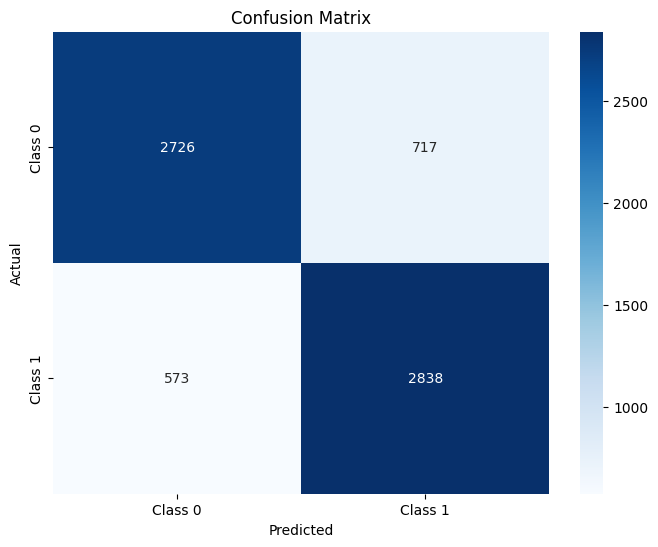

AUC: 0.8919488153726564
Weighted Precision: 0.8124


In [10]:
all_preds = []
all_labels = []
all_probs = [] 
model.eval()
with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_outputs = model(X_val)
        probabilities = torch.softmax(val_outputs, dim=1)[:, 1] 
        all_probs.extend(probabilities.cpu().numpy())
        _, preds = torch.max(val_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())


# Precision, recall, and F1-score
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
try:
    auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    auc = None 

# weighted precision
weighted_precision = precision_score(all_labels, all_preds, average='weighted')


print(f"AUC: {auc if auc is not None else 'Undefined'}")
print(f"Weighted Precision: {weighted_precision:.4f}")

### EfficientNet output

In [11]:
# model = get_nasnetlarge_base_model()
model = get_efficientnetb0_base_model()
# model = get_resnet18_base_model() 


scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.7, 1.3]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
best_val_loss = float("inf")
best_model_path = "base_effcientnet.pt"

epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)

        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()
        torch.cuda.empty_cache()

    # Step the learning rate scheduler
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = [] 

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            with torch.cuda.amp.autocast():
                val_outputs = model(X_val)
                val_loss += loss_fn(val_outputs, y_val).item()
                _, preds = torch.max(val_outputs, 1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

                probabilities = torch.softmax(val_outputs, dim=1)[:, 1]
                all_probs.extend(probabilities.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

            torch.cuda.empty_cache()

    val_loss /= len(test_loader)
    accuracy = correct / total
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model.")

    # Calculate AUC
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = None  

    all_preds_binary = [1 if pred >= 0.5 else 0 for pred in all_probs]
    weighted_precision = precision_score(all_labels, all_preds_binary, average='weighted')
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy * 100:.2f}%, AUC: {auc if auc is not None else 'Undefined'}, Weighted Precision: {weighted_precision:.4f}")

Epoch [1/50]: Validation loss improved to 0.6474. Saving model.
Epoch [1/50], Loss: 0.6439, Val Loss: 0.6474, Val Accuracy: 54.04%, AUC: 0.629117853746311, Weighted Precision: 0.5781
Epoch [2/50]: Validation loss improved to 0.6252. Saving model.
Epoch [2/50], Loss: 0.6096, Val Loss: 0.6252, Val Accuracy: 56.19%, AUC: 0.6341825787356736, Weighted Precision: 0.5979
Epoch [3/50]: Validation loss improved to 0.6217. Saving model.
Epoch [3/50], Loss: 0.5649, Val Loss: 0.6217, Val Accuracy: 59.69%, AUC: 0.6647322015113496, Weighted Precision: 0.6227
Epoch [4/50], Loss: 0.4693, Val Loss: 0.7230, Val Accuracy: 60.21%, AUC: 0.6587818382940911, Weighted Precision: 0.6155
Epoch [5/50], Loss: 0.3680, Val Loss: 0.8043, Val Accuracy: 60.27%, AUC: 0.6546408558598026, Weighted Precision: 0.6162
Epoch [6/50], Loss: 0.2581, Val Loss: 1.0889, Val Accuracy: 60.96%, AUC: 0.6546826641830308, Weighted Precision: 0.6113
Epoch [7/50], Loss: 0.2127, Val Loss: 1.1460, Val Accuracy: 60.99%, AUC: 0.64921650265627

              precision    recall  f1-score   support

     Class 0       0.62      0.63      0.63      3443
     Class 1       0.62      0.62      0.62      3411

    accuracy                           0.62      6854
   macro avg       0.62      0.62      0.62      6854
weighted avg       0.62      0.62      0.62      6854



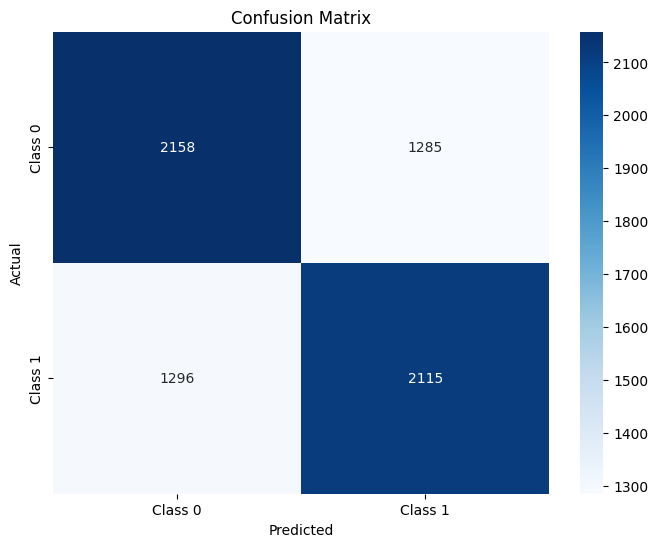

AUC: 0.6692533331494108
Weighted Precision: 0.6234


In [12]:
all_preds = []
all_labels = []
all_probs = [] 
model.eval()
with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_outputs = model(X_val)
        probabilities = torch.softmax(val_outputs, dim=1)[:, 1] 
        all_probs.extend(probabilities.cpu().numpy())
        _, preds = torch.max(val_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())


# Precision, recall, and F1-score
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
try:
    auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    auc = None 

# weighted precision
weighted_precision = precision_score(all_labels, all_preds, average='weighted')


print(f"AUC: {auc if auc is not None else 'Undefined'}")
print(f"Weighted Precision: {weighted_precision:.4f}")

### Nesnet output

In [3]:
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train, X_test, y_test = X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device)

model = get_nasnetlarge_base_model()

scaler = torch.cuda.amp.GradScaler()
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.7, 1.3]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
best_val_loss = float("inf")
best_model_path = "base_nesnet.pt"


epochs = 20
accumulation_steps = 4 

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch) / accumulation_steps

        # Backpropagation
        scaler.scale(loss).backward()

        # Gradient accumulation
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps  # Scale back the loss for logging

        # Clear unused memory
        torch.cuda.empty_cache()


    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = [] 

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            with torch.cuda.amp.autocast():
                val_outputs = model(X_val)
                val_loss += loss_fn(val_outputs, y_val).item()
                _, preds = torch.max(val_outputs, 1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

                probabilities = torch.softmax(val_outputs, dim=1)[:, 1]
                all_probs.extend(probabilities.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

            torch.cuda.empty_cache()

    val_loss /= len(test_loader)
    accuracy = correct / total
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model.")

    # Calculate AUC
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = None  

    all_preds_binary = [1 if pred >= 0.5 else 0 for pred in all_probs]
    weighted_precision = precision_score(all_labels, all_preds_binary, average='weighted')
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy * 100:.2f}%, AUC: {auc if auc is not None else 'Undefined'}, Weighted Precision: {weighted_precision:.4f}")

cuda
Epoch [1/20]: Validation loss improved to 0.7169. Saving model.
Epoch [1/20], Loss: 0.6488, Val Loss: 0.7169, Val Accuracy: 58.02%, AUC: 0.6272340950196751, Weighted Precision: 0.6259
Epoch [2/20]: Validation loss improved to 0.6130. Saving model.
Epoch [2/20], Loss: 0.6154, Val Loss: 0.6130, Val Accuracy: 55.41%, AUC: 0.7092212386622596, Weighted Precision: 0.6562
Epoch [3/20]: Validation loss improved to 0.5993. Saving model.
Epoch [3/20], Loss: 0.5937, Val Loss: 0.5993, Val Accuracy: 58.80%, AUC: 0.6999259115640715, Weighted Precision: 0.6492
Epoch [4/20]: Validation loss improved to 0.5467. Saving model.
Epoch [4/20], Loss: 0.5626, Val Loss: 0.5467, Val Accuracy: 67.90%, AUC: 0.7667822313434189, Weighted Precision: 0.6978
Epoch [5/20]: Validation loss improved to 0.5459. Saving model.
Epoch [5/20], Loss: 0.5263, Val Loss: 0.5459, Val Accuracy: 69.84%, AUC: 0.779176440745898, Weighted Precision: 0.7068
Epoch [6/20]: Validation loss improved to 0.4842. Saving model.
Epoch [6/20]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score


all_preds = []
all_labels = []
all_probs = [] 
model.eval()
with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_outputs = model(X_val)
        probabilities = torch.softmax(val_outputs, dim=1)[:, 1] 
        all_probs.extend(probabilities.cpu().numpy())
        _, preds = torch.max(val_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())


# Precision, recall, and F1-score
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
try:
    auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    auc = None 

# weighted precision
weighted_precision = precision_score(all_labels, all_preds, average='weighted')


print(f"AUC: {auc if auc is not None else 'Undefined'}")
print(f"Weighted Precision: {weighted_precision:.4f}")

# Transfer Learning

### Pretrained Resnet-18

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
best_val_loss = float("inf")
best_model_path = "customized_resnet.pt"

# Create the model
def get_model(num_classes=5):
    model = models.resnet18(pretrained=True)

    # Freeze all layers except the final fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Customize the fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  # Input features are fixed for ResNet18
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )

    # Loss function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.001)

    return model.to(device), loss_fn, optimizer

# Create the model, loss function, and optimizer
model, loss_fn, optimizer = get_model(num_classes=2)

# DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss += loss_fn(val_outputs, y_val).item()
            _, preds = torch.max(val_outputs, 1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    val_loss /= len(test_loader)
    accuracy = correct / total
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model.")


    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")


cuda


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]: Validation loss improved to 0.6347. Saving model.
Epoch [1/50], Loss: 0.6656, Val Loss: 0.6347, Val Accuracy: 63.25%
Epoch [2/50]: Validation loss improved to 0.6329. Saving model.
Epoch [2/50], Loss: 0.6331, Val Loss: 0.6329, Val Accuracy: 64.08%
Epoch [3/50]: Validation loss improved to 0.6209. Saving model.
Epoch [3/50], Loss: 0.6210, Val Loss: 0.6209, Val Accuracy: 65.01%
Epoch [4/50], Loss: 0.6101, Val Loss: 0.6222, Val Accuracy: 65.33%
Epoch [5/50], Loss: 0.6016, Val Loss: 0.6225, Val Accuracy: 64.84%
Epoch [6/50]: Validation loss improved to 0.6053. Saving model.
Epoch [6/50], Loss: 0.5937, Val Loss: 0.6053, Val Accuracy: 66.73%
Epoch [7/50], Loss: 0.5873, Val Loss: 0.6251, Val Accuracy: 64.91%
Epoch [8/50]: Validation loss improved to 0.5932. Saving model.
Epoch [8/50], Loss: 0.5789, Val Loss: 0.5932, Val Accuracy: 68.43%
Epoch [9/50], Loss: 0.5757, Val Loss: 0.5998, Val Accuracy: 66.98%
Epoch [10/50], Loss: 0.5655, Val Loss: 0.5971, Val Accuracy: 67.79%
Epoch [11

### Pretrined Effcient Net

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

# Move data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
best_val_loss = float("inf")
best_model_path = "pretrained_efficientnet.pt"

def get_model_2(num_classes=5):
    model = models.efficientnet_b0(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Customize the fully connected layer
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )

    # Loss function
    loss_fn = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.001)

    return model.to(device), loss_fn, optimizer

model, loss_fn, optimizer = get_model_2(num_classes=2)

# DataLoader for batching
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            val_loss += loss_fn(val_outputs, y_val).item()
            _, preds = torch.max(val_outputs, 1)
            correct += (preds == y_val).sum().item()
            total += y_val.size(0)

    val_loss /= len(test_loader)
    accuracy = correct / total
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model.")

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")


cuda


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]: Validation loss improved to 0.5573. Saving model.
Epoch [1/50], Loss: 0.6210, Val Loss: 0.5573, Val Accuracy: 70.97%
Epoch [2/50], Loss: 0.5680, Val Loss: 0.5632, Val Accuracy: 70.09%
Epoch [3/50]: Validation loss improved to 0.5193. Saving model.
Epoch [3/50], Loss: 0.5443, Val Loss: 0.5193, Val Accuracy: 73.97%
Epoch [4/50]: Validation loss improved to 0.5107. Saving model.
Epoch [4/50], Loss: 0.5323, Val Loss: 0.5107, Val Accuracy: 74.85%
Epoch [5/50]: Validation loss improved to 0.5102. Saving model.
Epoch [5/50], Loss: 0.5206, Val Loss: 0.5102, Val Accuracy: 74.45%
Epoch [6/50]: Validation loss improved to 0.4924. Saving model.
Epoch [6/50], Loss: 0.5079, Val Loss: 0.4924, Val Accuracy: 75.88%
Epoch [7/50]: Validation loss improved to 0.4836. Saving model.
Epoch [7/50], Loss: 0.5007, Val Loss: 0.4836, Val Accuracy: 76.77%
Epoch [8/50], Loss: 0.4956, Val Loss: 0.4888, Val Accuracy: 76.36%
Epoch [9/50]: Validation loss improved to 0.4743. Saving model.
Epoch [9/50], Lo

              precision    recall  f1-score   support

     Class 0       0.69      0.74      0.72      3443
     Class 1       0.72      0.67      0.69      3411

    accuracy                           0.71      6854
   macro avg       0.71      0.71      0.71      6854
weighted avg       0.71      0.71      0.71      6854



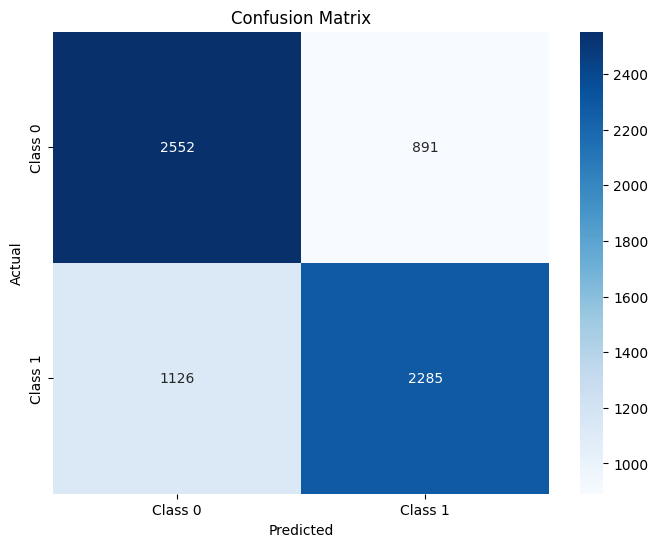

In [5]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and ground truth
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_outputs = model(X_val)
        _, preds = torch.max(val_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate precision, recall, and F1-score
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
print(report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Customized NesnetLarge

In [2]:
def get_nasnetlarge_model(num_classes=2):
    model = timm.create_model('nasnetalarge', pretrained=True)

    # fine-tune deeper layers
    for name, param in model.named_parameters():
        if "cell_17" in name or "cell_18" in name or "cell_19" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # custom fully connected layer
    model.last_linear = nn.Sequential(
        nn.Linear(model.num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes),
    )

    return model.to(device)

In [5]:
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)
model = get_nasnetlarge_model(num_classes=2)
# DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
scaler = torch.cuda.amp.GradScaler()

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.7, 1.3]).to(device))
optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': 1e-4}
], weight_decay=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
best_val_loss = float("inf")
best_model_path = "customized_nesnet2.pt"

# Training loop 
epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for i, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)


        with torch.cuda.amp.autocast():
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)

        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()

        torch.cuda.empty_cache()

    # Step the learning rate scheduler
    scheduler.step()

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    all_probs = []  

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            
            with torch.cuda.amp.autocast():
                val_outputs = model(X_val)
                val_loss += loss_fn(val_outputs, y_val).item()
                _, preds = torch.max(val_outputs, 1)
                correct += (preds == y_val).sum().item()
                total += y_val.size(0)

                
                probabilities = torch.softmax(val_outputs, dim=1)[:, 1]  # Extract probability for class 1
                all_probs.extend(probabilities.cpu().numpy())
                all_labels.extend(y_val.cpu().numpy())

        
            torch.cuda.empty_cache()

    val_loss /= len(test_loader)
    accuracy = correct / total
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model.")

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = None  

    all_preds_binary = [1 if pred >= 0.5 else 0 for pred in all_probs]


    weighted_precision = precision_score(all_labels, all_preds_binary, average='weighted')

    # Print training and validation results
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, "
          f"Val Accuracy: {accuracy * 100:.2f}%, AUC: {auc if auc is not None else 'Undefined'}, Weighted Precision: {weighted_precision:.4f}")


cuda
Epoch [1/50]: Validation loss improved to 0.5331. Saving model.
Epoch [1/50], Loss: 0.6084, Val Loss: 0.5331, Val Accuracy: 69.93%, AUC: 0.7838911168212255, Weighted Precision: 0.7088
Epoch [2/50]: Validation loss improved to 0.4799. Saving model.
Epoch [2/50], Loss: 0.4902, Val Loss: 0.4799, Val Accuracy: 71.78%, AUC: 0.8262485681075041, Weighted Precision: 0.7495
Epoch [3/50]: Validation loss improved to 0.4652. Saving model.
Epoch [3/50], Loss: 0.3761, Val Loss: 0.4652, Val Accuracy: 76.15%, AUC: 0.8490677382540113, Weighted Precision: 0.7693
Epoch [4/50], Loss: 0.2703, Val Loss: 0.5569, Val Accuracy: 76.76%, AUC: 0.8479418937535554, Weighted Precision: 0.7679
Epoch [5/50], Loss: 0.1902, Val Loss: 0.5224, Val Accuracy: 77.53%, AUC: 0.8634436281177749, Weighted Precision: 0.7787
Epoch [6/50], Loss: 0.0974, Val Loss: 0.5506, Val Accuracy: 79.15%, AUC: 0.8769218311228141, Weighted Precision: 0.7916
Epoch [7/50], Loss: 0.0616, Val Loss: 0.5701, Val Accuracy: 78.96%, AUC: 0.87898857

              precision    recall  f1-score   support

     Class 0       0.80      0.83      0.81      3443
     Class 1       0.82      0.79      0.80      3411

    accuracy                           0.81      6854
   macro avg       0.81      0.81      0.81      6854
weighted avg       0.81      0.81      0.81      6854



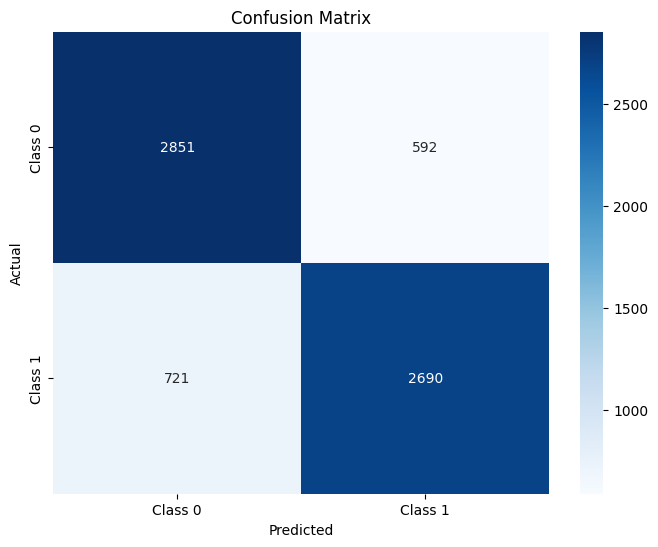

AUC: 0.8914119062441115
Weighted Precision: 0.8088


In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score


all_preds = []
all_labels = []
all_probs = [] 
model.eval()
with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_outputs = model(X_val)
        probabilities = torch.softmax(val_outputs, dim=1)[:, 1] 
        all_probs.extend(probabilities.cpu().numpy())
        _, preds = torch.max(val_outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())


# Precision, recall, and F1-score
report = classification_report(all_labels, all_preds, target_names=["Class 0", "Class 1"])
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# AUC
try:
    auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    auc = None 

# weighted precision
weighted_precision = precision_score(all_labels, all_preds, average='weighted')


print(f"AUC: {auc if auc is not None else 'Undefined'}")
print(f"Weighted Precision: {weighted_precision:.4f}")

## Tuning Hyperparameters
learning_rates = [0.1, 0.01, 0.2]

optimizers = ['adam', 'sgd']


### Resnet18

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

learning_rates = [0.1, 0.01, 0.2]
optimizers = ['adam', 'sgd']


def get_model(num_classes=2):
    model = models.resnet18(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Customize the fully connected layer
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )

    return model.to(device)

# Loop 
for lr in learning_rates:
    for opt in optimizers:
        print(f"\nStarting training with optimizer: {opt}, learning rate: {lr}")

        # Create the model
        model = get_model(num_classes=2)
        
        # Loss function
        loss_fn = nn.CrossEntropyLoss()

        # Optimizer setup
        if opt == 'adam':
            optimizer = optim.Adam(model.fc.parameters(), lr=lr, weight_decay=0.001)
        elif opt == 'sgd':
            optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9, weight_decay=0.001)

        
        best_model_path = f"best_model_{opt}_lr{lr}.pt"
        best_val_loss = float("inf")  

        # Training loop
        epochs = 50
        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for X_val, y_val in test_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    val_outputs = model(X_val)
                    val_loss += loss_fn(val_outputs, y_val).item()
                    _, preds = torch.max(val_outputs, 1)
                    correct += (preds == y_val).sum().item()
                    total += y_val.size(0)

            val_loss /= len(test_loader)
            accuracy = correct / total

            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"Epoch [{epoch+1}/{epochs}]: Validation loss improved to {val_loss:.4f}. Saving model to {best_model_path}")

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")

print(f"\nTraining complete. Models for each optimizer and learning rate combination have been saved.")


cuda

Starting training with optimizer: adam, learning rate: 0.1


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]: Validation loss improved to 0.6935. Saving model to best_model_adam_lr0.1.pt
Epoch [1/50], Loss: 0.7151, Val Loss: 0.6935, Val Accuracy: 50.73%
Epoch [2/50], Loss: 0.6975, Val Loss: 0.6948, Val Accuracy: 51.72%
Epoch [3/50], Loss: 0.6966, Val Loss: 0.7425, Val Accuracy: 49.77%
Epoch [4/50]: Validation loss improved to 0.6932. Saving model to best_model_adam_lr0.1.pt
Epoch [4/50], Loss: 0.6962, Val Loss: 0.6932, Val Accuracy: 50.23%
Epoch [5/50]: Validation loss improved to 0.6924. Saving model to best_model_adam_lr0.1.pt
Epoch [5/50], Loss: 0.6990, Val Loss: 0.6924, Val Accuracy: 51.36%
Epoch [6/50], Loss: 0.7009, Val Loss: 0.6938, Val Accuracy: 50.23%
Epoch [7/50], Loss: 0.7015, Val Loss: 0.6933, Val Accuracy: 49.77%
Epoch [8/50], Loss: 0.6991, Val Loss: 0.7008, Val Accuracy: 49.77%
Epoch [9/50], Loss: 0.7004, Val Loss: 0.8335, Val Accuracy: 55.28%
Epoch [10/50], Loss: 0.6972, Val Loss: 0.6947, Val Accuracy: 50.23%
Epoch [11/50], Loss: 0.6991, Val Loss: 0.7187, Val Accur

### EfficientNet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# DataLoader
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

learning_rates = [0.1, 0.01, 0.2, 0.001]
optimizers = ['adam', 'sgd']


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)


# Create the model
def get_model_2(num_classes=2):
    model = models.efficientnet_b0(pretrained=True)

    # Fine-tune deeper layers
    for name, param in model.named_parameters():
        if "features.6" in name or "features.7" in name or "features.8" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    # fully connected layer
    model.classifier = nn.Sequential(
        nn.Linear(model.classifier[1].in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(128, num_classes),
    )
    return model.to(device)


# Train and evaluate
for lr in learning_rates:
    for opt in optimizers:
        print(f"\nTraining with optimizer: {opt}, learning rate: {lr}")

        # Create the model
        model = get_model_2()

        # Loss function
        loss_fn = nn.CrossEntropyLoss()

        # Optimizer setup
        if opt == 'adam':
            optimizer = optim.Adam(model.classifier.parameters(), lr=lr, weight_decay=0.001)
        elif opt == 'sgd':
            optimizer = optim.SGD(model.classifier.parameters(), lr=lr, momentum=0.9, weight_decay=0.001)

        best_model_path = f"best_efficientnet_{opt}_lr{lr}.pt"
        best_val_loss = float("inf")

        # Training loop
        epochs = 50
        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            # Validation
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for X_val, y_val in test_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    val_outputs = model(X_val)
                    val_loss += loss_fn(val_outputs, y_val).item()
                    _, preds = torch.max(val_outputs, 1)
                    correct += (preds == y_val).sum().item()
                    total += y_val.size(0)

            val_loss /= len(test_loader)
            accuracy = correct / total

            # Save the best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"Epoch [{epoch+1}/{epochs}]: Val loss improved to {val_loss:.4f}. Saving model.")

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy * 100:.2f}%")

print("\nTraining complete.")


cuda


cuda

Training with optimizer: adam, learning rate: 0.1


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50]: Val loss improved to 0.6951. Saving model.
Epoch [1/50], Loss: 0.7178, Val Loss: 0.6951, Val Accuracy: 49.77%
Epoch [2/50], Loss: 0.7001, Val Loss: 0.8756, Val Accuracy: 49.82%
Epoch [3/50]: Val loss improved to 0.6943. Saving model.
Epoch [3/50], Loss: 0.7046, Val Loss: 0.6943, Val Accuracy: 51.25%
Epoch [4/50], Loss: 0.7012, Val Loss: 0.7129, Val Accuracy: 50.23%
Epoch [5/50], Loss: 0.7020, Val Loss: 0.6944, Val Accuracy: 51.25%
Epoch [6/50], Loss: 0.7016, Val Loss: 0.9162, Val Accuracy: 55.53%
Epoch [7/50]: Val loss improved to 0.6933. Saving model.
Epoch [7/50], Loss: 0.7000, Val Loss: 0.6933, Val Accuracy: 50.23%
Epoch [8/50], Loss: 0.7010, Val Loss: 0.6995, Val Accuracy: 50.18%
Epoch [9/50], Loss: 0.7008, Val Loss: 0.6948, Val Accuracy: 50.23%
Epoch [10/50], Loss: 0.7007, Val Loss: 0.6951, Val Accuracy: 49.91%
Epoch [11/50], Loss: 0.6989, Val Loss: 0.7243, Val Accuracy: 50.23%
Epoch [12/50]: Val loss improved to 0.6933. Saving model.
Epoch [12/50], Loss: 0.7021, Val

### Nesnet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, precision_score

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Move data to device
X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

# DataLoader for training and validation
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

# Learning rates and optimizers to try
learning_rates = [0.1, 0.01, 0.2]
optimizers = ['adam', 'sgd']

# Function to create NASNetLarge model
def get_nasnetlarge_model(num_classes=2):
    model = timm.create_model('nasnetalarge', pretrained=True)
    for name, param in model.named_parameters():
        if "cell_17" in name or "cell_18" in name or "cell_19" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    model.last_linear = nn.Sequential(
        nn.Linear(model.num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes),
    )
    return model.to(device)

# Train and evaluate for each combination of learning rate and optimizer
for lr in learning_rates:
    for opt in optimizers:
        print(f"\nTraining with optimizer: {opt}, learning rate: {lr}")

        model = get_nasnetlarge_model()
        loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([0.7, 1.3]).to(device))

        if opt == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
        elif opt == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.001)

        scaler = torch.cuda.amp.GradScaler()
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        best_model_path = f"best_nasnet_{opt}_lr{lr}.pt"
        best_val_loss = float("inf")

        epochs = 50
        for epoch in range(epochs):
            model.train()
            total_loss = 0

            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                with torch.cuda.amp.autocast():
                    outputs = model(X_batch)
                    loss = loss_fn(outputs, y_batch)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                total_loss += loss.item()
                torch.cuda.empty_cache()

            scheduler.step()

            # Validation
            model.eval()
            val_loss = 0
            correct = 0
            total = 0
            all_labels = []
            all_probs = []

            with torch.no_grad():
                for X_val, y_val in test_loader:
                    X_val, y_val = X_val.to(device), y_val.to(device)
                    with torch.cuda.amp.autocast():
                        val_outputs = model(X_val)
                        val_loss += loss_fn(val_outputs, y_val).item()
                        _, preds = torch.max(val_outputs, 1)
                        correct += (preds == y_val).sum().item()
                        total += y_val.size(0)

                        probabilities = torch.softmax(val_outputs, dim=1)[:, 1]
                        all_probs.extend(probabilities.cpu().numpy())
                        all_labels.extend(y_val.cpu().numpy())

                    torch.cuda.empty_cache()

            val_loss /= len(test_loader)
            accuracy = correct / total

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_path)
                print(f"Epoch [{epoch+1}/{epochs}]: Val loss improved to {val_loss:.4f}. Saving model.")

            try:
                auc = roc_auc_score(all_labels, all_probs)
            except ValueError:
                auc = None

            all_preds_binary = [1 if pred >= 0.5 else 0 for pred in all_probs]
            weighted_precision = precision_score(all_labels, all_preds_binary, average='weighted')

            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}, "
                  f"Val Accuracy: {accuracy * 100:.2f}%, AUC: {auc if auc is not None else 'Undefined'}, Weighted Precision: {weighted_precision:.4f}")

print("\nTraining complete.")


cuda

Training with optimizer: adam, learning rate: 0.1
Epoch [1/50]: Val loss improved to 0.7587. Saving model.
Epoch [1/50], Loss: 0.6917, Val Loss: 0.7587, Val Accuracy: 49.77%, AUC: 0.5840562724703772, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [2/50], Loss: 0.6562, Val Loss: 0.8837, Val Accuracy: 49.77%, AUC: 0.5969906692507787, Weighted Precision: 0.2477
Epoch [3/50]: Val loss improved to 0.6526. Saving model.
Epoch [3/50], Loss: 0.6567, Val Loss: 0.6526, Val Accuracy: 49.77%, AUC: 0.5818931387773221, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4/50]: Val loss improved to 0.6512. Saving model.
Epoch [4/50], Loss: 0.6542, Val Loss: 0.6512, Val Accuracy: 49.77%, AUC: 0.5007261109497532, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/50]: Val loss improved to 0.6501. Saving model.
Epoch [5/50], Loss: 0.6540, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/50]: Val loss improved to 0.6500. Saving model.
Epoch [6/50], Loss: 0.6497, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/50], Loss: 0.6497, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [8/50], Loss: 0.6495, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/50], Loss: 0.6496, Val Loss: 0.6518, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/50], Loss: 0.6496, Val Loss: 0.6524, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [11/50], Loss: 0.6491, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/50], Loss: 0.6491, Val Loss: 0.6524, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/50], Loss: 0.6488, Val Loss: 0.6507, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [14/50], Loss: 0.6487, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/50], Loss: 0.6489, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/50], Loss: 0.6488, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477
Epoch [17/50]: Val loss improved to 0.6499. Saving model.
Epoch [17/50], Loss: 0.6488, Val Loss: 0.6499, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/50], Loss: 0.6490, Val Loss: 0.6510, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/50], Loss: 0.6487, Val Loss: 0.6508, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/50], Loss: 0.6490, Val Loss: 0.6510, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [21/50], Loss: 0.6486, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [22/50], Loss: 0.6488, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [23/50], Loss: 0.6486, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [24/50], Loss: 0.6486, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [25/50], Loss: 0.6487, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [26/50], Loss: 0.6487, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [27/50], Loss: 0.6485, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [28/50], Loss: 0.6484, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [29/50], Loss: 0.6487, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [30/50], Loss: 0.6485, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [31/50], Loss: 0.6485, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [32/50], Loss: 0.6487, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [33/50], Loss: 0.6483, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [34/50], Loss: 0.6485, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [35/50], Loss: 0.6487, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [36/50], Loss: 0.6485, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [37/50], Loss: 0.6485, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [38/50], Loss: 0.6483, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [39/50], Loss: 0.6484, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [40/50], Loss: 0.6484, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [41/50], Loss: 0.6484, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [42/50], Loss: 0.6483, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [43/50], Loss: 0.6484, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [44/50], Loss: 0.6486, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477
Epoch [45/50]: Val loss improved to 0.6499. Saving model.
Epoch [45/50], Loss: 0.6484, Val Loss: 0.6499, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [46/50], Loss: 0.6483, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [47/50], Loss: 0.6484, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [48/50], Loss: 0.6484, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [49/50], Loss: 0.6483, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [50/50], Loss: 0.6484, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477

Training with optimizer: sgd, learning rate: 0.1
Epoch [1/50]: Val loss improved to 0.5542. Saving model.
Epoch [1/50], Loss: 0.7187, Val Loss: 0.5542, Val Accuracy: 66.43%, AUC: 0.7703869006945034, Weighted Precision: 0.6973
Epoch [2/50]: Val loss improved to 0.5271. Saving model.
Epoch [2/50], Loss: 0.5174, Val Loss: 0.5271, Val Accuracy: 71.93%, AUC: 0.8027139732527206, Weighted Precision: 0.7223
Epoch [3/50]: Val loss improved to 0.4987. Saving model.
Epoch [3/50], Loss: 0.4614, Val Loss: 0.4987, Val Accuracy: 72.38%, AUC: 0.8133604074157237, Weighted Precision: 0.7364
Epoch [4/50]: Val loss improved to 0.4850. Saving model.
Epoch [4/50], Loss: 0.4248, Val Loss: 0.4850, Val Accuracy: 72.56%, AUC: 0.8341966624355963, Weighted Precision: 0.7489
Epoch [5/50], Loss: 0.4071, Val Loss: 0.5150, Val Accuracy: 72.66%, AUC: 0.8164139051247382, Weighted Precision: 0.7389
Epoch [6/50]: Va

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3/50], Loss: 0.6623, Val Loss: 1.4297, Val Accuracy: 49.77%, AUC: 0.48862741231257667, Weighted Precision: 0.2477
Epoch [4/50]: Val loss improved to 0.6506. Saving model.
Epoch [4/50], Loss: 0.6605, Val Loss: 0.6506, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [5/50], Loss: 0.6600, Val Loss: 0.6535, Val Accuracy: 49.77%, AUC: 0.500435666569852, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [6/50], Loss: 0.6506, Val Loss: 0.6507, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [7/50], Loss: 0.6504, Val Loss: 0.6519, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477
Epoch [8/50]: Val loss improved to 0.6503. Saving model.
Epoch [8/50], Loss: 0.6505, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [9/50]: Val loss improved to 0.6501. Saving model.
Epoch [9/50], Loss: 0.6510, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [10/50], Loss: 0.6504, Val Loss: 0.6580, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477
Epoch [11/50]: Val loss improved to 0.6500. Saving model.
Epoch [11/50], Loss: 0.6503, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [12/50], Loss: 0.6502, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [13/50], Loss: 0.6502, Val Loss: 0.6510, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477
Epoch [14/50]: Val loss improved to 0.6500. Saving model.
Epoch [14/50], Loss: 0.6491, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [15/50], Loss: 0.6500, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [16/50], Loss: 0.6491, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [17/50], Loss: 0.6495, Val Loss: 0.6506, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [18/50], Loss: 0.6492, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [19/50], Loss: 0.6494, Val Loss: 0.6505, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [20/50], Loss: 0.6492, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [21/50], Loss: 0.6489, Val Loss: 0.6504, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [22/50], Loss: 0.6490, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [23/50], Loss: 0.6488, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [24/50], Loss: 0.6487, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [25/50], Loss: 0.6489, Val Loss: 0.6508, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [26/50], Loss: 0.6486, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [27/50], Loss: 0.6483, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [28/50], Loss: 0.6487, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [29/50], Loss: 0.6485, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477
Epoch [30/50]: Val loss improved to 0.6499. Saving model.
Epoch [30/50], Loss: 0.6487, Val Loss: 0.6499, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [31/50], Loss: 0.6485, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [32/50], Loss: 0.6486, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [33/50], Loss: 0.6485, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [34/50], Loss: 0.6486, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [35/50], Loss: 0.6486, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [36/50], Loss: 0.6488, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [37/50], Loss: 0.6485, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [38/50], Loss: 0.6485, Val Loss: 0.6503, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [39/50], Loss: 0.6483, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [40/50], Loss: 0.6486, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [41/50], Loss: 0.6487, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [42/50], Loss: 0.6485, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [43/50], Loss: 0.6485, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [44/50], Loss: 0.6484, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [45/50], Loss: 0.6484, Val Loss: 0.6499, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477
Epoch [46/50]: Val loss improved to 0.6499. Saving model.
Epoch [46/50], Loss: 0.6485, Val Loss: 0.6499, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [47/50], Loss: 0.6485, Val Loss: 0.6501, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [48/50], Loss: 0.6486, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [49/50], Loss: 0.6484, Val Loss: 0.6502, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [50/50], Loss: 0.6488, Val Loss: 0.6500, Val Accuracy: 49.77%, AUC: 0.5, Weighted Precision: 0.2477

Training with optimizer: sgd, learning rate: 0.2
